# 📈 Week 5.1: Linear Models Trading Strategy

## OLS, Ridge, Lasso & Elastic Net for Return Prediction

---

### 🎯 Objective
Build a comprehensive trading strategy using linear regression models to predict stock returns and generate trading signals. We'll compare multiple regularization techniques and evaluate their effectiveness in a real-world trading context.

### 📚 Topics Covered
- **Ordinary Least Squares (OLS)**: Baseline linear regression without regularization
- **Ridge Regression (L2)**: Shrinks coefficients to reduce overfitting
- **Lasso Regression (L1)**: Performs feature selection via sparsity
- **Elastic Net**: Combines L1 and L2 penalties for balanced regularization
- **Cross-Sectional Regression**: Factor analysis across multiple assets

### 🔗 Building on Previous Weeks
- **Week 1-2**: Python fundamentals, NumPy, Pandas operations
- **Week 3**: Time series analysis, returns calculation, volatility
- **Week 4**: ML foundations, train/test splits, cross-validation
- **Week 5**: Portfolio optimization, risk metrics

---

**Author**: Quantitative Trading Analyst  
**Date**: Week 5.1 - Linear Models Module  
**Version**: 1.0

## 1️⃣ Configuration & Setup

Define the tickers and parameters for the strategy. You can easily modify these to analyze different assets.

In [1]:
# ============================================================
# CONFIGURATION - MODIFY THESE PARAMETERS AS NEEDED
# ============================================================

# Tickers to analyze (dynamic - change as needed)
# Tech stocks: AAPL, GOOGL, MSFT | Finance stocks: GS, JPM
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']

# Date range for analysis
START_DATE = '2020-01-01'
END_DATE = '2025-12-31'

# Model parameters
LOOKBACK_PERIOD = 20  # Days for feature calculation
PREDICTION_HORIZON = 5  # Days ahead to predict
TEST_SIZE = 0.2  # Proportion for testing
N_SPLITS = 5  # Number of time series cross-validation splits

# Regularization parameters for grid search
ALPHA_RANGE = [0.001, 0.01, 0.1, 1.0, 10.0]
L1_RATIO_RANGE = [0.1, 0.3, 0.5, 0.7, 0.9]  # For Elastic Net

# Trading parameters
TRANSACTION_COST = 0.001  # 10 bps per trade
SIGNAL_THRESHOLD = 0.0  # Threshold for long/short signals

print(f"📊 Strategy Configuration")
print(f"{'='*50}")
print(f"Tickers: {TICKERS}")
print(f"Period: {START_DATE} to {END_DATE}")
print(f"Lookback: {LOOKBACK_PERIOD} days")
print(f"Prediction Horizon: {PREDICTION_HORIZON} days")

📊 Strategy Configuration
Tickers: ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
Period: 2020-01-01 to 2025-12-31
Lookback: 20 days
Prediction Horizon: 5 days


## 2️⃣ Import Libraries

Import all necessary libraries for data processing, modeling, and visualization.

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Data fetching
import yfinance as yf

# Machine Learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Statistical analysis
import statsmodels.api as sm
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 3️⃣ Data Acquisition

Fetch historical price data from Yahoo Finance for all specified tickers. We'll download adjusted close prices and volume data for comprehensive analysis.

In [3]:
def fetch_stock_data(tickers: list, start: str, end: str) -> dict:
    """
    Fetch historical stock data for multiple tickers.
    
    Parameters:
    -----------
    tickers : list
        List of stock ticker symbols
    start : str
        Start date in 'YYYY-MM-DD' format
    end : str
        End date in 'YYYY-MM-DD' format
    
    Returns:
    --------
    dict : Dictionary with 'prices' and 'volume' DataFrames
    """
    print(f"📥 Downloading data for {len(tickers)} tickers...")
    
    # Download all data at once
    data = yf.download(tickers, start=start, end=end, progress=False)
    
    # Extract adjusted close and volume (yfinance auto_adjust=True uses 'Close')
    if len(tickers) == 1:
        prices = data['Close'].to_frame(name=tickers[0])
        volume = data['Volume'].to_frame(name=tickers[0])
        high = data['High'].to_frame(name=tickers[0])
        low = data['Low'].to_frame(name=tickers[0])
        open_price = data['Open'].to_frame(name=tickers[0])
    else:
        prices = data['Close']
        volume = data['Volume']
        high = data['High']
        low = data['Low']
        open_price = data['Open']
    
    # Drop any rows with missing data
    prices = prices.dropna()
    
    print(f"✅ Downloaded {len(prices)} trading days of data")
    print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
    
    return {
        'prices': prices,
        'volume': volume,
        'high': high,
        'low': low,
        'open': open_price
    }

# Fetch the data
stock_data = fetch_stock_data(TICKERS, START_DATE, END_DATE)
prices = stock_data['prices']
volume = stock_data['volume']

# Display sample data
print("\n📊 Sample Price Data:")
prices.tail()

📥 Downloading data for 5 tickers...


✅ Downloaded 1507 trading days of data
📅 Date range: 2020-01-02 to 2025-12-30

📊 Sample Price Data:


Ticker,AAPL,GOOGL,GS,JPM,MSFT
Date,,,,,
2025-12-23,272.359985,314.350006,901.710022,324.466400,486.850006
2025-12-24,273.809998,314.089996,910.780029,327.691864,488.019989
2025-12-26,273.399994,313.510010,907.039978,326.437531,487.709991
2025-12-29,273.760010,313.559998,892.179993,322.296204,487.100006
2025-12-30,273.079987,313.850006,884.419983,321.967712,487.480011


## 4️⃣ Feature Engineering

Create predictive features from price and volume data. These features capture various market dynamics:

### Feature Categories:
1. **Return Features**: Past returns at various horizons
2. **Momentum Indicators**: RSI, moving average ratios
3. **Volatility Features**: Rolling standard deviation, ATR-like measures
4. **Volume Features**: Volume trends and ratios
5. **Technical Indicators**: Bollinger Band position, price momentum

In [4]:
def create_features(prices_df: pd.DataFrame, volume_df: pd.DataFrame, 
                    lookback: int = 20) -> pd.DataFrame:
    """
    Create comprehensive feature set for return prediction.
    
    Parameters:
    -----------
    prices_df : pd.DataFrame
        DataFrame with adjusted close prices
    volume_df : pd.DataFrame
        DataFrame with trading volume
    lookback : int
        Lookback period for rolling calculations
    
    Returns:
    --------
    pd.DataFrame : Feature matrix for each ticker
    """
    all_features = {}
    
    for ticker in prices_df.columns:
        price = prices_df[ticker]
        vol = volume_df[ticker]
        
        features = pd.DataFrame(index=prices_df.index)
        
        # =====================
        # RETURN FEATURES
        # =====================
        # Daily returns
        features['ret_1d'] = price.pct_change(1)
        features['ret_5d'] = price.pct_change(5)
        features['ret_10d'] = price.pct_change(10)
        features['ret_20d'] = price.pct_change(20)
        
        # Log returns (for better statistical properties)
        features['log_ret_1d'] = np.log(price / price.shift(1))
        features['log_ret_5d'] = np.log(price / price.shift(5))
        
        # =====================
        # MOMENTUM FEATURES
        # =====================
        # Moving average ratios
        features['ma_ratio_5_20'] = price.rolling(5).mean() / price.rolling(20).mean()
        features['ma_ratio_10_50'] = price.rolling(10).mean() / price.rolling(50).mean()
        
        # Price relative to moving averages
        features['price_to_ma20'] = price / price.rolling(20).mean()
        features['price_to_ma50'] = price / price.rolling(50).mean()
        
        # RSI (Relative Strength Index)
        delta = price.diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        features['rsi_14'] = 100 - (100 / (1 + rs))
        
        # Momentum
        features['momentum_10'] = price / price.shift(10) - 1
        features['momentum_20'] = price / price.shift(20) - 1
        
        # =====================
        # VOLATILITY FEATURES
        # =====================
        # Rolling volatility
        features['volatility_10'] = features['ret_1d'].rolling(10).std()
        features['volatility_20'] = features['ret_1d'].rolling(20).std()
        features['volatility_60'] = features['ret_1d'].rolling(60).std()
        
        # Volatility ratio (short-term vs long-term)
        features['vol_ratio'] = features['volatility_10'] / features['volatility_60']
        
        # High-Low range (proxy for intraday volatility)
        features['range_pct'] = (stock_data['high'][ticker] - stock_data['low'][ticker]) / price
        features['avg_range_10'] = features['range_pct'].rolling(10).mean()
        
        # =====================
        # VOLUME FEATURES
        # =====================
        # Volume ratios
        features['vol_ratio_5_20'] = vol.rolling(5).mean() / vol.rolling(20).mean()
        features['vol_ma_ratio'] = vol / vol.rolling(20).mean()
        
        # Volume trend
        features['vol_trend'] = vol.pct_change(5)
        
        # =====================
        # TECHNICAL INDICATORS
        # =====================
        # Bollinger Band position
        ma20 = price.rolling(20).mean()
        std20 = price.rolling(20).std()
        features['bb_position'] = (price - ma20) / (2 * std20)
        
        # Distance from 52-week high/low
        features['dist_52w_high'] = price / price.rolling(252).max() - 1
        features['dist_52w_low'] = price / price.rolling(252).min() - 1
        
        # Rate of change
        features['roc_10'] = (price - price.shift(10)) / price.shift(10)
        
        # =====================
        # MEAN REVERSION FEATURES
        # =====================
        features['zscore_20'] = (price - price.rolling(20).mean()) / price.rolling(20).std()
        features['zscore_60'] = (price - price.rolling(60).mean()) / price.rolling(60).std()
        
        all_features[ticker] = features
    
    return all_features

# Create features for all tickers
print("🔧 Engineering features...")
features_dict = create_features(prices, volume, LOOKBACK_PERIOD)

# Display feature summary
sample_ticker = TICKERS[0]
print(f"\n✅ Created {len(features_dict[sample_ticker].columns)} features per ticker")
print(f"\n📋 Feature List:")
for i, col in enumerate(features_dict[sample_ticker].columns, 1):
    print(f"  {i:2d}. {col}")

🔧 Engineering features...

✅ Created 28 features per ticker

📋 Feature List:
   1. ret_1d
   2. ret_5d
   3. ret_10d
   4. ret_20d
   5. log_ret_1d
   6. log_ret_5d
   7. ma_ratio_5_20
   8. ma_ratio_10_50
   9. price_to_ma20
  10. price_to_ma50
  11. rsi_14
  12. momentum_10
  13. momentum_20
  14. volatility_10
  15. volatility_20
  16. volatility_60
  17. vol_ratio
  18. range_pct
  19. avg_range_10
  20. vol_ratio_5_20
  21. vol_ma_ratio
  22. vol_trend
  23. bb_position
  24. dist_52w_high
  25. dist_52w_low
  26. roc_10
  27. zscore_20
  28. zscore_60


## 5️⃣ Target Variable Construction

Create the target variable: **Forward Returns** over the prediction horizon.

We predict the return over the next `N` days, where `N = PREDICTION_HORIZON`.

In [5]:
def create_target(prices_df: pd.DataFrame, horizon: int = 5) -> dict:
    """
    Create forward return targets for prediction.
    
    Parameters:
    -----------
    prices_df : pd.DataFrame
        DataFrame with adjusted close prices
    horizon : int
        Number of days ahead to predict
    
    Returns:
    --------
    dict : Dictionary of target series for each ticker
    """
    targets = {}
    
    for ticker in prices_df.columns:
        # Forward return: (P_t+h - P_t) / P_t
        targets[ticker] = prices_df[ticker].pct_change(horizon).shift(-horizon)
        # Alternative: log returns
        # targets[ticker] = np.log(prices_df[ticker].shift(-horizon) / prices_df[ticker])
    
    return targets

# Create targets
targets_dict = create_target(prices, PREDICTION_HORIZON)

print(f"🎯 Target: {PREDICTION_HORIZON}-day forward return")
print(f"\n📊 Target Statistics for {sample_ticker}:")
target_stats = targets_dict[sample_ticker].dropna().describe()
print(target_stats)

🎯 Target: 5-day forward return

📊 Target Statistics for AAPL:
count    1502.000000
mean        0.005311
std         0.041825
min        -0.227474
25%        -0.019025
50%         0.005617
75%         0.029838
max         0.184141
Name: AAPL, dtype: float64


## 6️⃣ Data Preparation for Modeling

Prepare clean datasets for model training:
1. Combine features and targets
2. Remove rows with missing values
3. Apply time series train/test split

In [6]:
def prepare_modeling_data(features_dict: dict, targets_dict: dict, 
                          test_size: float = 0.2) -> dict:
    """
    Prepare data for modeling with train/test split.
    
    Parameters:
    -----------
    features_dict : dict
        Dictionary of feature DataFrames
    targets_dict : dict
        Dictionary of target Series
    test_size : float
        Proportion of data for testing
    
    Returns:
    --------
    dict : Prepared data for each ticker
    """
    prepared_data = {}
    
    for ticker in features_dict.keys():
        # Combine features and target
        df = features_dict[ticker].copy()
        df['target'] = targets_dict[ticker]
        
        # Drop missing values
        df = df.dropna()
        
        # Split data (time series - no shuffling!)
        split_idx = int(len(df) * (1 - test_size))
        
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        
        # Separate features and target
        feature_cols = [col for col in df.columns if col != 'target']
        
        X_train = train_df[feature_cols]
        y_train = train_df['target']
        X_test = test_df[feature_cols]
        y_test = test_df['target']
        
        prepared_data[ticker] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'feature_cols': feature_cols,
            'train_dates': train_df.index,
            'test_dates': test_df.index,
            'full_df': df
        }
        
        print(f"  {ticker}: Train={len(X_train)}, Test={len(X_test)} samples")
    
    return prepared_data

print("📦 Preparing modeling data...")
model_data = prepare_modeling_data(features_dict, targets_dict, TEST_SIZE)
print("\n✅ Data preparation complete!")

📦 Preparing modeling data...
  AAPL: Train=1000, Test=251 samples
  GOOGL: Train=1000, Test=251 samples
  GS: Train=1000, Test=251 samples
  JPM: Train=1000, Test=251 samples
  MSFT: Train=1000, Test=251 samples

✅ Data preparation complete!


## 7️⃣ Model Training: OLS, Ridge, Lasso, Elastic Net

### Model Comparison Framework

| Model | Regularization | Key Property | Best For |
|-------|---------------|--------------|----------|
| **OLS** | None | Unbiased estimates | Baseline, interpretability |
| **Ridge** | L2 (squared) | Shrinks all coefficients | Multicollinearity, many features |
| **Lasso** | L1 (absolute) | Sparse solutions | Feature selection |
| **Elastic Net** | L1 + L2 | Best of both | Correlated features, selection |

### Mathematical Formulation

**OLS**: $\min_\beta \|y - X\beta\|_2^2$

**Ridge**: $\min_\beta \|y - X\beta\|_2^2 + \alpha\|\beta\|_2^2$

**Lasso**: $\min_\beta \|y - X\beta\|_2^2 + \alpha\|\beta\|_1$

**Elastic Net**: $\min_\beta \|y - X\beta\|_2^2 + \alpha\rho\|\beta\|_1 + \frac{\alpha(1-\rho)}{2}\|\beta\|_2^2$

In [7]:
def train_all_models(X_train: pd.DataFrame, y_train: pd.Series, 
                     n_splits: int = 5) -> dict:
    """
    Train all linear models with hyperparameter tuning.
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features
    y_train : pd.Series
        Training target
    n_splits : int
        Number of time series CV splits
    
    Returns:
    --------
    dict : Trained models and their CV scores
    """
    # Initialize time series cross-validator
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    models = {}
    
    # 1. OLS (Ordinary Least Squares)
    print("  Training OLS...")
    ols = LinearRegression()
    ols.fit(X_scaled, y_train)
    models['OLS'] = {
        'model': ols,
        'scaler': scaler,
        'best_params': None
    }
    
    # 2. Ridge Regression
    print("  Training Ridge with CV...")
    ridge_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge())
    ])
    ridge_params = {'ridge__alpha': ALPHA_RANGE}
    ridge_cv = GridSearchCV(ridge_pipe, ridge_params, cv=tscv, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
    ridge_cv.fit(X_train, y_train)
    models['Ridge'] = {
        'model': ridge_cv.best_estimator_,
        'scaler': None,  # Included in pipeline
        'best_params': ridge_cv.best_params_,
        'cv_score': -ridge_cv.best_score_
    }
    
    # 3. Lasso Regression
    print("  Training Lasso with CV...")
    lasso_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(max_iter=10000))
    ])
    lasso_params = {'lasso__alpha': ALPHA_RANGE}
    lasso_cv = GridSearchCV(lasso_pipe, lasso_params, cv=tscv,
                            scoring='neg_mean_squared_error', n_jobs=-1)
    lasso_cv.fit(X_train, y_train)
    models['Lasso'] = {
        'model': lasso_cv.best_estimator_,
        'scaler': None,
        'best_params': lasso_cv.best_params_,
        'cv_score': -lasso_cv.best_score_
    }
    
    # 4. Elastic Net
    print("  Training Elastic Net with CV...")
    enet_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('enet', ElasticNet(max_iter=10000))
    ])
    enet_params = {
        'enet__alpha': ALPHA_RANGE,
        'enet__l1_ratio': L1_RATIO_RANGE
    }
    enet_cv = GridSearchCV(enet_pipe, enet_params, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=-1)
    enet_cv.fit(X_train, y_train)
    models['ElasticNet'] = {
        'model': enet_cv.best_estimator_,
        'scaler': None,
        'best_params': enet_cv.best_params_,
        'cv_score': -enet_cv.best_score_
    }
    
    return models

# Train models for all tickers
all_models = {}
print("🤖 Training models for each ticker...\n")

for ticker in TICKERS:
    print(f"📈 {ticker}:")
    data = model_data[ticker]
    all_models[ticker] = train_all_models(
        data['X_train'], data['y_train'], N_SPLITS
    )
    print()

print("✅ All models trained successfully!")

🤖 Training models for each ticker...

📈 AAPL:
  Training OLS...
  Training Ridge with CV...
  Training Lasso with CV...
  Training Elastic Net with CV...

📈 GOOGL:
  Training OLS...
  Training Ridge with CV...
  Training Lasso with CV...
  Training Elastic Net with CV...

📈 MSFT:
  Training OLS...
  Training Ridge with CV...
  Training Lasso with CV...
  Training Elastic Net with CV...

📈 GS:
  Training OLS...
  Training Ridge with CV...
  Training Lasso with CV...
  Training Elastic Net with CV...

📈 JPM:
  Training OLS...
  Training Ridge with CV...
  Training Lasso with CV...
  Training Elastic Net with CV...

✅ All models trained successfully!


## 8️⃣ Model Evaluation & Comparison

Evaluate all models on the test set using multiple metrics:
- **MSE**: Mean Squared Error (lower is better)
- **MAE**: Mean Absolute Error (lower is better)  
- **R²**: Coefficient of Determination (higher is better)
- **IC**: Information Coefficient (correlation with actual returns)

In [8]:
def evaluate_models(models: dict, X_test: pd.DataFrame, 
                    y_test: pd.Series) -> pd.DataFrame:
    """
    Evaluate all models and return performance metrics.
    
    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    X_test : pd.DataFrame
        Test features
    y_test : pd.Series
        Test target
    
    Returns:
    --------
    pd.DataFrame : Performance metrics for each model
    """
    results = []
    predictions = {}
    
    for model_name, model_info in models.items():
        model = model_info['model']
        
        # Make predictions
        if model_name == 'OLS':
            scaler = model_info['scaler']
            X_scaled = scaler.transform(X_test)
            y_pred = model.predict(X_scaled)
        else:
            y_pred = model.predict(X_test)
        
        predictions[model_name] = y_pred
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Information Coefficient (Spearman correlation)
        ic, _ = stats.spearmanr(y_test, y_pred)
        
        # Directional accuracy
        direction_correct = np.mean(np.sign(y_test) == np.sign(y_pred))
        
        results.append({
            'Model': model_name,
            'MSE': mse,
            'RMSE': np.sqrt(mse),
            'MAE': mae,
            'R²': r2,
            'IC': ic,
            'Direction Accuracy': direction_correct,
            'Best Params': str(model_info.get('best_params', 'N/A'))
        })
    
    return pd.DataFrame(results), predictions

# Evaluate all models for each ticker
all_results = {}
all_predictions = {}

print("📊 Evaluating models on test data...\n")

for ticker in TICKERS:
    data = model_data[ticker]
    results_df, preds = evaluate_models(
        all_models[ticker], data['X_test'], data['y_test']
    )
    all_results[ticker] = results_df
    all_predictions[ticker] = preds
    
    print(f"\n{'='*60}")
    print(f"📈 {ticker} - Model Performance Comparison")
    print(f"{'='*60}")
    display_df = results_df[['Model', 'RMSE', 'MAE', 'R²', 'IC', 'Direction Accuracy']].copy()
    display_df['RMSE'] = display_df['RMSE'].apply(lambda x: f"{x:.6f}")
    display_df['MAE'] = display_df['MAE'].apply(lambda x: f"{x:.6f}")
    display_df['R²'] = display_df['R²'].apply(lambda x: f"{x:.4f}")
    display_df['IC'] = display_df['IC'].apply(lambda x: f"{x:.4f}")
    display_df['Direction Accuracy'] = display_df['Direction Accuracy'].apply(lambda x: f"{x:.2%}")
    print(display_df.to_string(index=False))

📊 Evaluating models on test data...


📈 AAPL - Model Performance Comparison
     Model     RMSE      MAE      R²     IC Direction Accuracy
       OLS 0.047134 0.036128  0.0047 0.1334             51.00%
     Ridge 0.047420 0.035830 -0.0074 0.1188             49.80%
     Lasso 0.047274 0.034707 -0.0012    nan             51.39%
ElasticNet 0.047274 0.034707 -0.0012    nan             51.39%

📈 GOOGL - Model Performance Comparison
     Model     RMSE      MAE      R²     IC Direction Accuracy
       OLS 0.045464 0.035885 -0.0600 0.1583             57.77%
     Ridge 0.045547 0.035919 -0.0639 0.1399             56.18%
     Lasso 0.044530 0.034863 -0.0169    nan             58.57%
ElasticNet 0.044530 0.034863 -0.0169    nan             58.57%

📈 MSFT - Model Performance Comparison
     Model     RMSE      MAE      R²      IC Direction Accuracy
       OLS 0.035110 0.026037 -0.1397 -0.2400             46.61%
     Ridge 0.035252 0.026131 -0.1489 -0.3209             45.02%
     Lasso 0.032913 0.0

## 9️⃣ Visualization: Model Performance Comparison

Create comprehensive visualizations to compare model performance across all tickers.

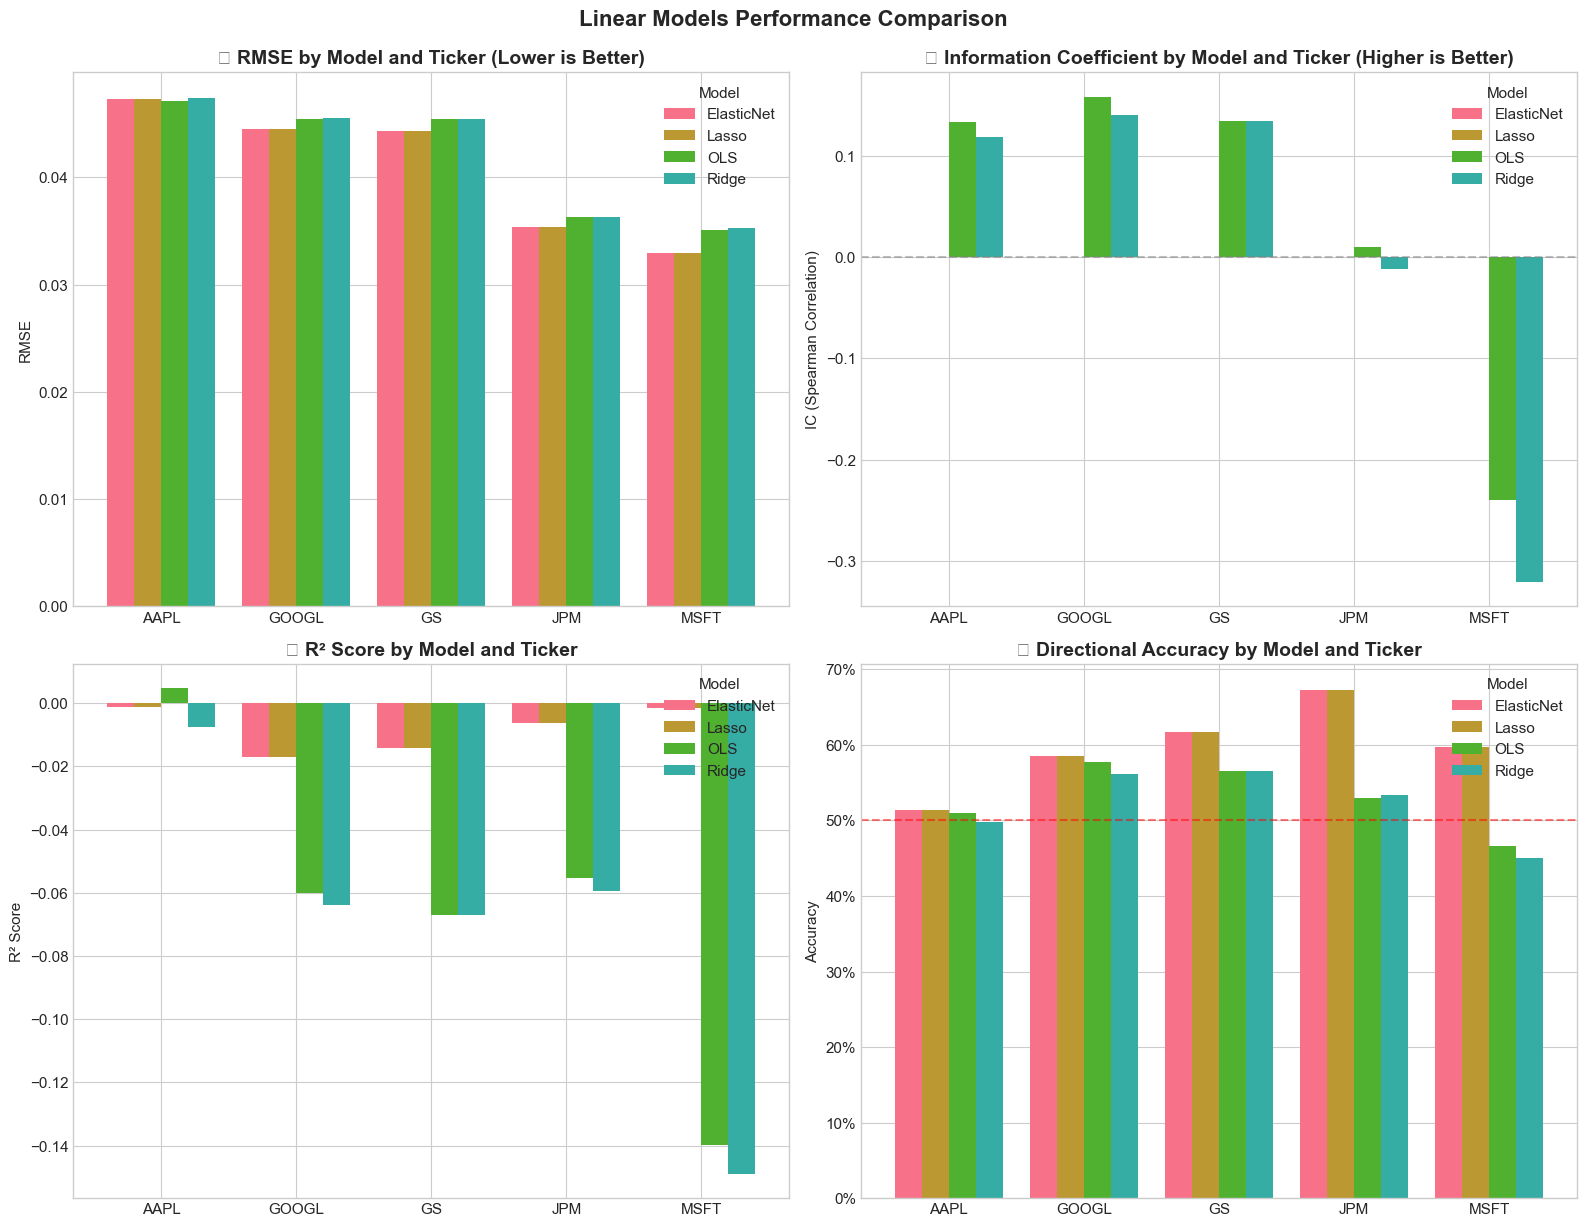

In [9]:
# Aggregate results across all tickers
combined_results = []
for ticker in TICKERS:
    df = all_results[ticker].copy()
    df['Ticker'] = ticker
    combined_results.append(df)

combined_df = pd.concat(combined_results, ignore_index=True)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE Comparison
ax1 = axes[0, 0]
pivot_rmse = combined_df.pivot(index='Ticker', columns='Model', values='RMSE')
pivot_rmse.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('📉 RMSE by Model and Ticker (Lower is Better)', fontsize=14, fontweight='bold')
ax1.set_ylabel('RMSE')
ax1.set_xlabel('')
ax1.legend(title='Model', loc='upper right')
ax1.tick_params(axis='x', rotation=0)

# 2. Information Coefficient (IC)
ax2 = axes[0, 1]
pivot_ic = combined_df.pivot(index='Ticker', columns='Model', values='IC')
pivot_ic.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('📊 Information Coefficient by Model and Ticker (Higher is Better)', fontsize=14, fontweight='bold')
ax2.set_ylabel('IC (Spearman Correlation)')
ax2.set_xlabel('')
ax2.legend(title='Model', loc='upper right')
ax2.tick_params(axis='x', rotation=0)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 3. R² Score
ax3 = axes[1, 0]
pivot_r2 = combined_df.pivot(index='Ticker', columns='Model', values='R²')
pivot_r2.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('📈 R² Score by Model and Ticker', fontsize=14, fontweight='bold')
ax3.set_ylabel('R² Score')
ax3.set_xlabel('')
ax3.legend(title='Model', loc='upper right')
ax3.tick_params(axis='x', rotation=0)

# 4. Direction Accuracy
ax4 = axes[1, 1]
pivot_dir = combined_df.pivot(index='Ticker', columns='Model', values='Direction Accuracy')
pivot_dir.plot(kind='bar', ax=ax4, width=0.8)
ax4.set_title('🎯 Directional Accuracy by Model and Ticker', fontsize=14, fontweight='bold')
ax4.set_ylabel('Accuracy')
ax4.set_xlabel('')
ax4.legend(title='Model', loc='upper right')
ax4.tick_params(axis='x', rotation=0)
ax4.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.tight_layout()
plt.suptitle('Linear Models Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 🔟 Feature Importance Analysis

Analyze which features are most important for predictions. Lasso naturally performs feature selection, making it ideal for this analysis.

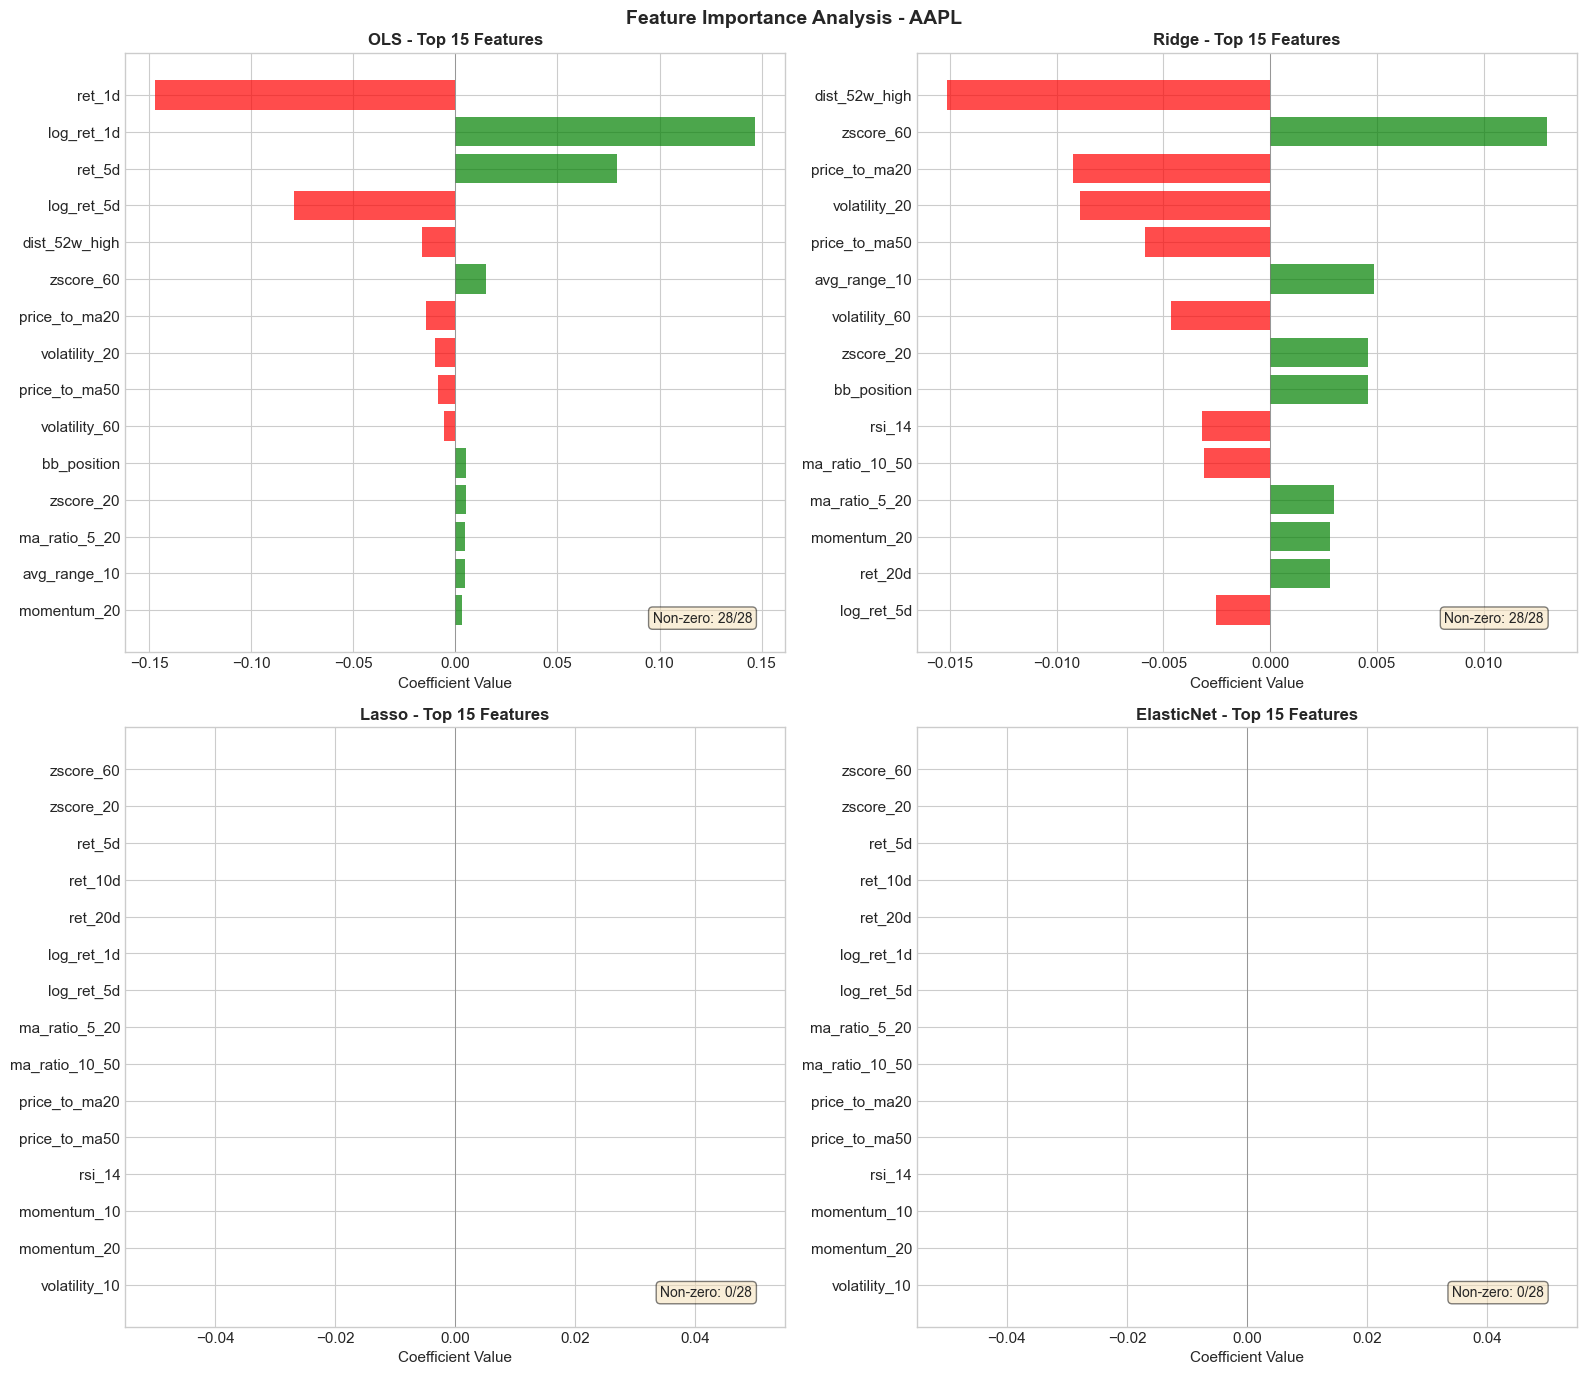

In [10]:
def plot_feature_importance(models: dict, feature_names: list, ticker: str):
    """
    Plot feature importance for all models.
    
    Parameters:
    -----------
    models : dict
        Trained models dictionary
    feature_names : list
        List of feature names
    ticker : str
        Ticker symbol for title
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    model_names = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
    
    for idx, (model_name, ax) in enumerate(zip(model_names, axes.flat)):
        model_info = models[model_name]
        model = model_info['model']
        
        # Extract coefficients
        if model_name == 'OLS':
            coefs = model.coef_
        elif model_name == 'ElasticNet':
            # ElasticNet pipeline step is named 'enet'
            coefs = model.named_steps['enet'].coef_
        else:
            # For pipeline models
            coefs = model.named_steps[model_name.lower()].coef_
        
        # Create DataFrame for plotting
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefs
        })
        coef_df['Abs_Coef'] = np.abs(coef_df['Coefficient'])
        coef_df = coef_df.sort_values('Abs_Coef', ascending=True).tail(15)
        
        # Plot
        colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
        ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
        ax.set_title(f'{model_name} - Top 15 Features', fontsize=12, fontweight='bold')
        ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
        ax.set_xlabel('Coefficient Value')
        
        # Count non-zero features (for Lasso/ElasticNet)
        non_zero = np.sum(np.abs(coefs) > 1e-10)
        ax.text(0.95, 0.05, f'Non-zero: {non_zero}/{len(coefs)}', 
                transform=ax.transAxes, ha='right', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Feature Importance Analysis - {ticker}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot feature importance for first ticker
sample_ticker = TICKERS[0]
feature_names = model_data[sample_ticker]['feature_cols']
plot_feature_importance(all_models[sample_ticker], feature_names, sample_ticker)

## 1️⃣1️⃣ Cross-Sectional Regression Analysis

Perform cross-sectional regression to analyze factor exposures across all assets simultaneously. This is commonly used in factor investing to determine:
- Factor risk premiums
- Stock-specific alpha
- Cross-sectional factor loadings

In [11]:
def cross_sectional_regression(prices_df: pd.DataFrame, 
                                features_dict: dict,
                                lookback: int = 60) -> pd.DataFrame:
    """
    Perform cross-sectional regression analysis.
    
    For each time period, regress returns across assets on their factor exposures.
    
    Parameters:
    -----------
    prices_df : pd.DataFrame
        Price data for all tickers
    features_dict : dict
        Features for each ticker
    lookback : int
        Number of periods for rolling regression
    
    Returns:
    --------
    pd.DataFrame : Factor premium time series
    """
    # Calculate forward returns
    returns = prices_df.pct_change(5).shift(-5)
    
    # Select common factors for cross-sectional analysis
    factor_names = ['momentum_20', 'volatility_20', 'rsi_14', 'vol_ratio_5_20', 'zscore_20']
    
    # Get common dates
    common_dates = returns.dropna().index
    
    factor_premiums = []
    
    for date in common_dates[-lookback:]:
        # Cross-sectional data for this date
        ret_cross = returns.loc[date]
        
        factor_cross = pd.DataFrame(index=prices_df.columns)
        for factor in factor_names:
            for ticker in prices_df.columns:
                if factor in features_dict[ticker].columns:
                    if date in features_dict[ticker].index:
                        factor_cross.loc[ticker, factor] = features_dict[ticker].loc[date, factor]
        
        # Drop rows with missing data
        factor_cross = factor_cross.dropna()
        ret_cross = ret_cross.loc[factor_cross.index]
        
        if len(factor_cross) >= 3:  # Need at least 3 assets
            # Run cross-sectional regression
            X = sm.add_constant(factor_cross.astype(float))
            y = ret_cross.astype(float)
            
            try:
                model = sm.OLS(y, X).fit()
                
                premium_dict = {'Date': date}
                premium_dict['Intercept'] = model.params.get('const', 0)
                for factor in factor_names:
                    if factor in model.params:
                        premium_dict[factor] = model.params[factor]
                        premium_dict[f'{factor}_tstat'] = model.tvalues.get(factor, 0)
                
                factor_premiums.append(premium_dict)
            except:
                continue
    
    return pd.DataFrame(factor_premiums)

# Perform cross-sectional analysis
print("🔬 Running cross-sectional regression analysis...")
cs_results = cross_sectional_regression(prices, features_dict)

if len(cs_results) > 0:
    cs_results = cs_results.set_index('Date')
    
    # Display summary statistics
    factor_cols = ['momentum_20', 'volatility_20', 'rsi_14', 'vol_ratio_5_20', 'zscore_20']
    
    print("\n📊 Factor Premium Summary Statistics:")
    print("="*60)
    
    summary_data = []
    for factor in factor_cols:
        if factor in cs_results.columns:
            mean_premium = cs_results[factor].mean()
            std_premium = cs_results[factor].std()
            t_stat = mean_premium / (std_premium / np.sqrt(len(cs_results)))
            pct_positive = (cs_results[factor] > 0).mean()
            
            summary_data.append({
                'Factor': factor,
                'Mean Premium': f"{mean_premium:.6f}",
                'Std Dev': f"{std_premium:.6f}",
                'T-Stat': f"{t_stat:.2f}",
                '% Positive': f"{pct_positive:.1%}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
else:
    print("⚠️ Insufficient data for cross-sectional analysis")

🔬 Running cross-sectional regression analysis...

📊 Factor Premium Summary Statistics:
        Factor Mean Premium  Std Dev T-Stat % Positive
   momentum_20     0.256495 1.533315   1.30      58.3%
 volatility_20     0.570860 1.481278   2.99      73.3%
        rsi_14     0.001256 0.011368   0.86      56.7%
vol_ratio_5_20     0.049421 0.545803   0.70      48.3%
     zscore_20    -0.030735 0.259111  -0.92      50.0%


## 1️⃣2️⃣ Trading Signal Generation

Generate trading signals based on model predictions:
- **Long Signal**: Predicted return > threshold
- **Short Signal**: Predicted return < -threshold  
- **Neutral**: Within threshold band

We'll use the best-performing model for each ticker based on IC (Information Coefficient).

In [12]:
def generate_trading_signals(models: dict, X: pd.DataFrame, 
                              threshold: float = 0.0) -> pd.DataFrame:
    """
    Generate trading signals from model predictions.
    
    Parameters:
    -----------
    models : dict
        Trained models
    X : pd.DataFrame
        Feature data
    threshold : float
        Signal threshold
    
    Returns:
    --------
    pd.DataFrame : Predictions and signals for each model
    """
    signals = pd.DataFrame(index=X.index)
    
    for model_name, model_info in models.items():
        model = model_info['model']
        
        # Make predictions
        if model_name == 'OLS':
            scaler = model_info['scaler']
            X_scaled = scaler.transform(X)
            pred = model.predict(X_scaled)
        else:
            pred = model.predict(X)
        
        signals[f'{model_name}_Prediction'] = pred
        signals[f'{model_name}_Signal'] = np.where(
            pred > threshold, 1,  # Long
            np.where(pred < -threshold, -1, 0)  # Short or Neutral
        )
    
    return signals

# Generate signals for all tickers
all_signals = {}

for ticker in TICKERS:
    data = model_data[ticker]
    signals = generate_trading_signals(
        all_models[ticker], 
        data['X_test'],
        SIGNAL_THRESHOLD
    )
    signals['Actual_Return'] = data['y_test']
    all_signals[ticker] = signals

# Display latest signals
print("📡 Latest Trading Signals (Test Period):")
print("="*80)

for ticker in TICKERS:
    latest = all_signals[ticker].iloc[-1]
    print(f"\n📈 {ticker}:")
    for model in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
        pred = latest[f'{model}_Prediction']
        sig = latest[f'{model}_Signal']
        signal_text = '🟢 LONG' if sig == 1 else ('🔴 SHORT' if sig == -1 else '⚪ NEUTRAL')
        print(f"  {model:12s}: Pred={pred:+.4f} → {signal_text}")

📡 Latest Trading Signals (Test Period):

📈 AAPL:
  OLS         : Pred=+0.0037 → 🟢 LONG
  Ridge       : Pred=+0.0066 → 🟢 LONG
  Lasso       : Pred=+0.0041 → 🟢 LONG
  ElasticNet  : Pred=+0.0041 → 🟢 LONG

📈 GOOGL:
  OLS         : Pred=+0.0076 → 🟢 LONG
  Ridge       : Pred=+0.0090 → 🟢 LONG
  Lasso       : Pred=+0.0049 → 🟢 LONG
  ElasticNet  : Pred=+0.0049 → 🟢 LONG

📈 MSFT:
  OLS         : Pred=+0.0032 → 🟢 LONG
  Ridge       : Pred=+0.0055 → 🟢 LONG
  Lasso       : Pred=+0.0042 → 🟢 LONG
  ElasticNet  : Pred=+0.0042 → 🟢 LONG

📈 GS:
  OLS         : Pred=+0.0020 → 🟢 LONG
  Ridge       : Pred=+0.0020 → 🟢 LONG
  Lasso       : Pred=+0.0051 → 🟢 LONG
  ElasticNet  : Pred=+0.0051 → 🟢 LONG

📈 JPM:
  OLS         : Pred=+0.0021 → 🟢 LONG
  Ridge       : Pred=+0.0023 → 🟢 LONG
  Lasso       : Pred=+0.0043 → 🟢 LONG
  ElasticNet  : Pred=+0.0043 → 🟢 LONG


## 1️⃣3️⃣ Backtesting Trading Strategy

Backtest the trading signals to evaluate strategy performance:
- Calculate strategy returns based on signals
- Account for transaction costs
- Compare to buy-and-hold benchmark

In [13]:
def backtest_strategy(signals_df: pd.DataFrame, prices: pd.Series,
                      model_name: str, transaction_cost: float = 0.001) -> dict:
    """
    Backtest trading strategy for a single model.
    
    Parameters:
    -----------
    signals_df : pd.DataFrame
        DataFrame with signals and predictions
    prices : pd.Series
        Price series for the asset
    model_name : str
        Name of the model to backtest
    transaction_cost : float
        Transaction cost per trade (as fraction)
    
    Returns:
    --------
    dict : Backtest results
    """
    # Get signals for the test period
    signal_col = f'{model_name}_Signal'
    signals = signals_df[signal_col]
    
    # Calculate daily returns (using actual returns from test data)
    actual_returns = signals_df['Actual_Return'] / PREDICTION_HORIZON  # Approximate daily
    
    # Strategy returns (signal * return)
    strategy_returns = signals.shift(1) * actual_returns
    strategy_returns = strategy_returns.fillna(0)
    
    # Transaction costs (when signal changes)
    signal_changes = signals.diff().abs()
    costs = signal_changes * transaction_cost
    
    # Net returns
    net_returns = strategy_returns - costs
    
    # Calculate cumulative returns
    cumulative_strategy = (1 + net_returns).cumprod()
    cumulative_benchmark = (1 + actual_returns).cumprod()
    
    # Performance metrics
    total_return = cumulative_strategy.iloc[-1] - 1
    benchmark_return = cumulative_benchmark.iloc[-1] - 1
    
    # Annualized metrics (assuming 252 trading days)
    n_days = len(net_returns)
    ann_return = (1 + total_return) ** (252 / n_days) - 1
    ann_vol = net_returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Max drawdown
    rolling_max = cumulative_strategy.cummax()
    drawdown = (cumulative_strategy - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Win rate
    winning_trades = (strategy_returns > 0).sum()
    total_trades = (strategy_returns != 0).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    return {
        'cumulative_returns': cumulative_strategy,
        'cumulative_benchmark': cumulative_benchmark,
        'total_return': total_return,
        'benchmark_return': benchmark_return,
        'ann_return': ann_return,
        'ann_volatility': ann_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'n_trades': total_trades
    }

# Backtest all models for all tickers
backtest_results = {}

for ticker in TICKERS:
    backtest_results[ticker] = {}
    for model_name in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
        results = backtest_strategy(
            all_signals[ticker],
            prices[ticker].loc[all_signals[ticker].index],
            model_name,
            TRANSACTION_COST
        )
        backtest_results[ticker][model_name] = results

# Display backtest summary
print("📊 Backtest Performance Summary")
print("="*100)

for ticker in TICKERS:
    print(f"\n📈 {ticker}:")
    print("-"*90)
    print(f"{'Model':<12} {'Total Ret':>12} {'Ann. Ret':>12} {'Ann. Vol':>12} {'Sharpe':>10} {'MaxDD':>10} {'Win Rate':>10}")
    print("-"*90)
    
    for model_name in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
        r = backtest_results[ticker][model_name]
        print(f"{model_name:<12} {r['total_return']:>+11.2%} {r['ann_return']:>+11.2%} "
              f"{r['ann_volatility']:>11.2%} {r['sharpe_ratio']:>10.2f} "
              f"{r['max_drawdown']:>10.2%} {r['win_rate']:>10.2%}")
    
    # Benchmark
    bench = backtest_results[ticker]['OLS']['benchmark_return']
    print(f"{'Buy & Hold':<12} {bench:>+11.2%}")

📊 Backtest Performance Summary

📈 AAPL:
------------------------------------------------------------------------------------------
Model           Total Ret     Ann. Ret     Ann. Vol     Sharpe      MaxDD   Win Rate
------------------------------------------------------------------------------------------
OLS              +12.57%     +12.62%      15.14%       0.83    -18.33%     49.60%
Ridge             +1.84%      +1.84%      15.16%       0.12    -21.22%     46.80%
Lasso            +12.24%     +12.29%      15.06%       0.82    -25.35%     51.60%
ElasticNet       +12.24%     +12.29%      15.06%       0.82    -25.35%     51.60%
Buy & Hold       +12.03%

📈 GOOGL:
------------------------------------------------------------------------------------------
Model           Total Ret     Ann. Ret     Ann. Vol     Sharpe      MaxDD   Win Rate
------------------------------------------------------------------------------------------
OLS              +20.76%     +20.85%      14.58%       1.43    

## 1️⃣4️⃣ Strategy Performance Visualization

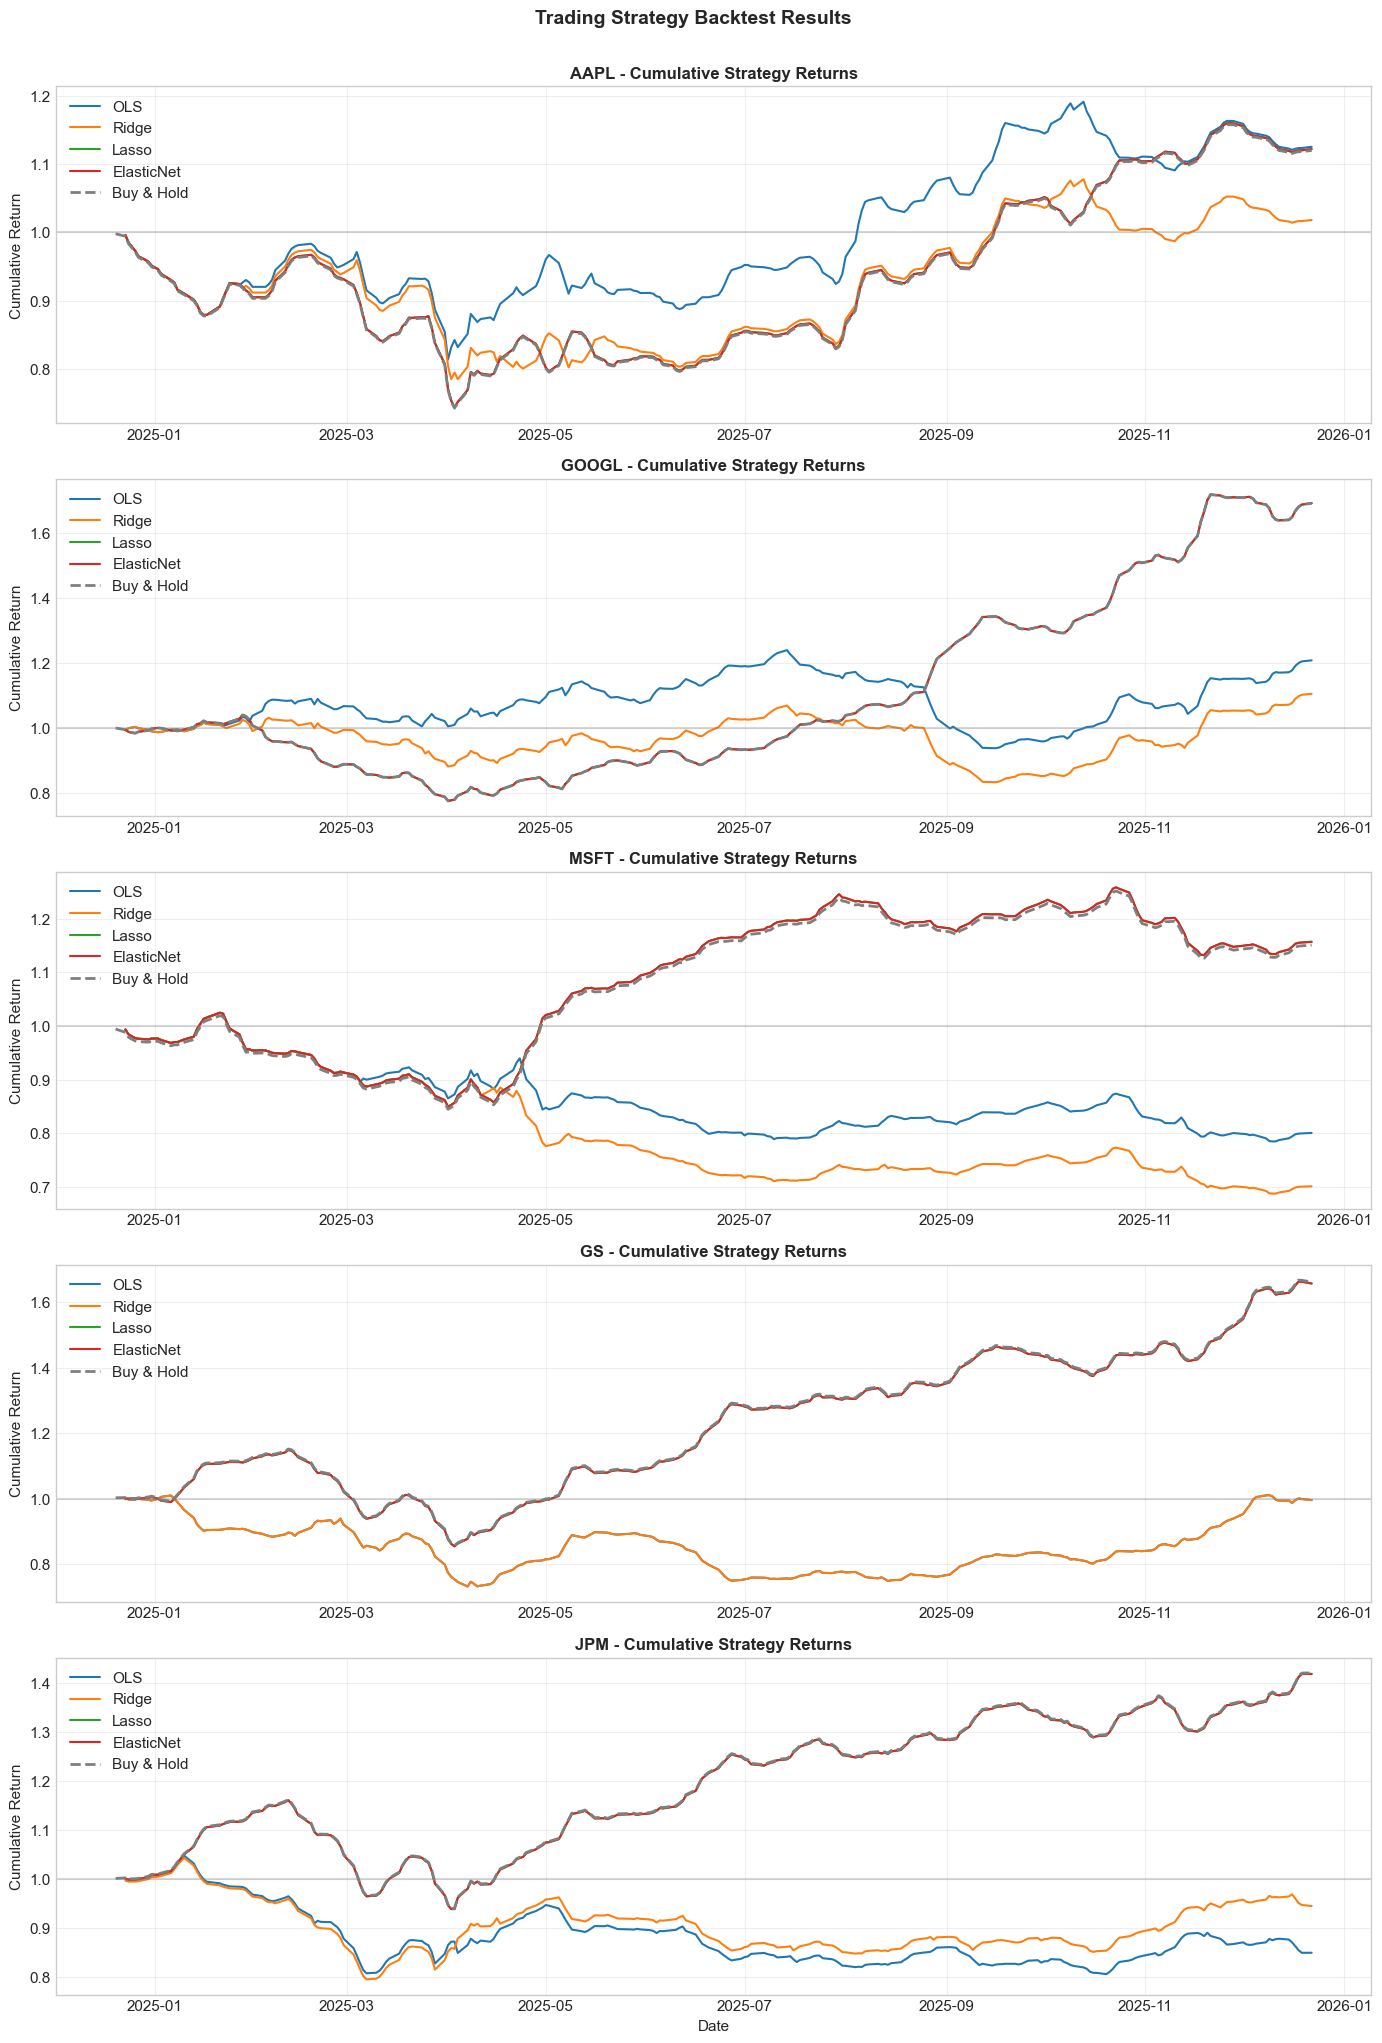

In [14]:
# Plot cumulative returns for each ticker
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(14, 4*len(TICKERS)))
if len(TICKERS) == 1:
    axes = [axes]

colors = {'OLS': '#1f77b4', 'Ridge': '#ff7f0e', 'Lasso': '#2ca02c', 
          'ElasticNet': '#d62728', 'Benchmark': '#7f7f7f'}

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    
    for model_name in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
        cum_ret = backtest_results[ticker][model_name]['cumulative_returns']
        ax.plot(cum_ret.index, cum_ret.values, label=model_name, 
                color=colors[model_name], linewidth=1.5)
    
    # Benchmark
    bench = backtest_results[ticker]['OLS']['cumulative_benchmark']
    ax.plot(bench.index, bench.values, label='Buy & Hold', 
            color=colors['Benchmark'], linewidth=2, linestyle='--')
    
    ax.set_title(f'{ticker} - Cumulative Strategy Returns', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Return')
    ax.legend(loc='upper left')
    ax.axhline(y=1, color='gray', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.suptitle('Trading Strategy Backtest Results', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 1️⃣5️⃣ Model Selection & Best Model Analysis

In [15]:
def select_best_model(backtest_results: dict, metric: str = 'sharpe_ratio') -> dict:
    """
    Select the best performing model for each ticker.
    
    Parameters:
    -----------
    backtest_results : dict
        Backtest results for all models and tickers
    metric : str
        Metric to use for selection
    
    Returns:
    --------
    dict : Best model for each ticker
    """
    best_models = {}
    
    for ticker in backtest_results.keys():
        best_metric = -np.inf
        best_model = None
        
        for model_name, results in backtest_results[ticker].items():
            if results[metric] > best_metric:
                best_metric = results[metric]
                best_model = model_name
        
        best_models[ticker] = {
            'model': best_model,
            metric: best_metric,
            'results': backtest_results[ticker][best_model]
        }
    
    return best_models

# Select best models
best_models = select_best_model(backtest_results, 'sharpe_ratio')

print("🏆 Best Model Selection (by Sharpe Ratio)")
print("="*70)

for ticker in TICKERS:
    best = best_models[ticker]
    r = best['results']
    print(f"\n📈 {ticker}:")
    print(f"   Best Model: {best['model']}")
    print(f"   Sharpe Ratio: {r['sharpe_ratio']:.2f}")
    print(f"   Annual Return: {r['ann_return']:+.2%}")
    print(f"   Max Drawdown: {r['max_drawdown']:.2%}")
    print(f"   Win Rate: {r['win_rate']:.2%}")

🏆 Best Model Selection (by Sharpe Ratio)

📈 AAPL:
   Best Model: OLS
   Sharpe Ratio: 0.83
   Annual Return: +12.62%
   Max Drawdown: -18.33%
   Win Rate: 49.60%

📈 GOOGL:
   Best Model: Lasso
   Sharpe Ratio: 4.93
   Annual Return: +69.40%
   Max Drawdown: -25.39%
   Win Rate: 58.80%

📈 MSFT:
   Best Model: Lasso
   Sharpe Ratio: 1.51
   Annual Return: +15.78%
   Max Drawdown: -17.11%
   Win Rate: 60.00%

📈 GS:
   Best Model: Lasso
   Sharpe Ratio: 4.71
   Annual Return: +66.04%
   Max Drawdown: -25.60%
   Win Rate: 61.60%

📈 JPM:
   Best Model: Lasso
   Sharpe Ratio: 3.74
   Annual Return: +42.10%
   Max Drawdown: -19.13%
   Win Rate: 67.20%


## 1️⃣6️⃣ Current Signals & Recommendations

Generate current trading signals using the most recent data and the best-performing models.

In [16]:
def get_current_signals(features_dict: dict, all_models: dict, 
                         best_models: dict) -> pd.DataFrame:
    """
    Generate current trading signals using the best model for each ticker.
    
    Parameters:
    -----------
    features_dict : dict
        Feature data for all tickers
    all_models : dict
        All trained models
    best_models : dict
        Best model selection for each ticker
    
    Returns:
    --------
    pd.DataFrame : Current signals and recommendations
    """
    current_signals = []
    
    for ticker in features_dict.keys():
        # Get latest feature data
        features = features_dict[ticker].dropna()
        if len(features) == 0:
            continue
            
        latest_features = features.iloc[[-1]]
        latest_date = features.index[-1]
        
        # Get best model
        best_model_name = best_models[ticker]['model']
        model_info = all_models[ticker][best_model_name]
        model = model_info['model']
        
        # Make prediction
        if best_model_name == 'OLS':
            scaler = model_info['scaler']
            X_scaled = scaler.transform(latest_features)
            prediction = model.predict(X_scaled)[0]
        else:
            prediction = model.predict(latest_features)[0]
        
        # Generate signal
        if prediction > SIGNAL_THRESHOLD:
            signal = 'LONG'
            emoji = '🟢'
        elif prediction < -SIGNAL_THRESHOLD:
            signal = 'SHORT'
            emoji = '🔴'
        else:
            signal = 'NEUTRAL'
            emoji = '⚪'
        
        # Confidence (based on prediction magnitude)
        confidence = min(abs(prediction) / 0.05 * 100, 100)  # Scale to 100%
        
        current_signals.append({
            'Ticker': ticker,
            'Date': latest_date.strftime('%Y-%m-%d'),
            'Best Model': best_model_name,
            'Predicted Return': prediction,
            'Signal': signal,
            'Signal Emoji': emoji,
            'Confidence': confidence
        })
    
    return pd.DataFrame(current_signals)

# Generate current signals
current_signals_df = get_current_signals(features_dict, all_models, best_models)

print("\n" + "="*80)
print("🚦 CURRENT TRADING SIGNALS & RECOMMENDATIONS")
print("="*80)
print(f"\n📅 Signal Date: {current_signals_df['Date'].iloc[0]}")
print(f"⏱️  Prediction Horizon: {PREDICTION_HORIZON} trading days")
print("\n")

for _, row in current_signals_df.iterrows():
    print(f"{row['Signal Emoji']} {row['Ticker']:6s} | {row['Signal']:8s} | "
          f"Pred: {row['Predicted Return']:+.4f} | Model: {row['Best Model']:10s} | "
          f"Confidence: {row['Confidence']:.0f}%")

print("\n" + "-"*80)
print("📝 SIGNAL INTERPRETATION:")
print("   🟢 LONG  = Model predicts positive returns - Consider buying")
print("   🔴 SHORT = Model predicts negative returns - Consider selling/shorting")
print("   ⚪ NEUTRAL = Model prediction near zero - Hold/No action")


🚦 CURRENT TRADING SIGNALS & RECOMMENDATIONS

📅 Signal Date: 2025-12-30
⏱️  Prediction Horizon: 5 trading days


🟢 AAPL   | LONG     | Pred: +0.0090 | Model: OLS        | Confidence: 18%
🟢 GOOGL  | LONG     | Pred: +0.0049 | Model: Lasso      | Confidence: 10%
🟢 GS     | LONG     | Pred: +0.0051 | Model: Lasso      | Confidence: 10%
🟢 JPM    | LONG     | Pred: +0.0043 | Model: Lasso      | Confidence: 9%
🟢 MSFT   | LONG     | Pred: +0.0042 | Model: Lasso      | Confidence: 8%

--------------------------------------------------------------------------------
📝 SIGNAL INTERPRETATION:
   🟢 LONG  = Model predicts positive returns - Consider buying
   🔴 SHORT = Model predicts negative returns - Consider selling/shorting
   ⚪ NEUTRAL = Model prediction near zero - Hold/No action


## 1️⃣7️⃣ Summary Dashboard

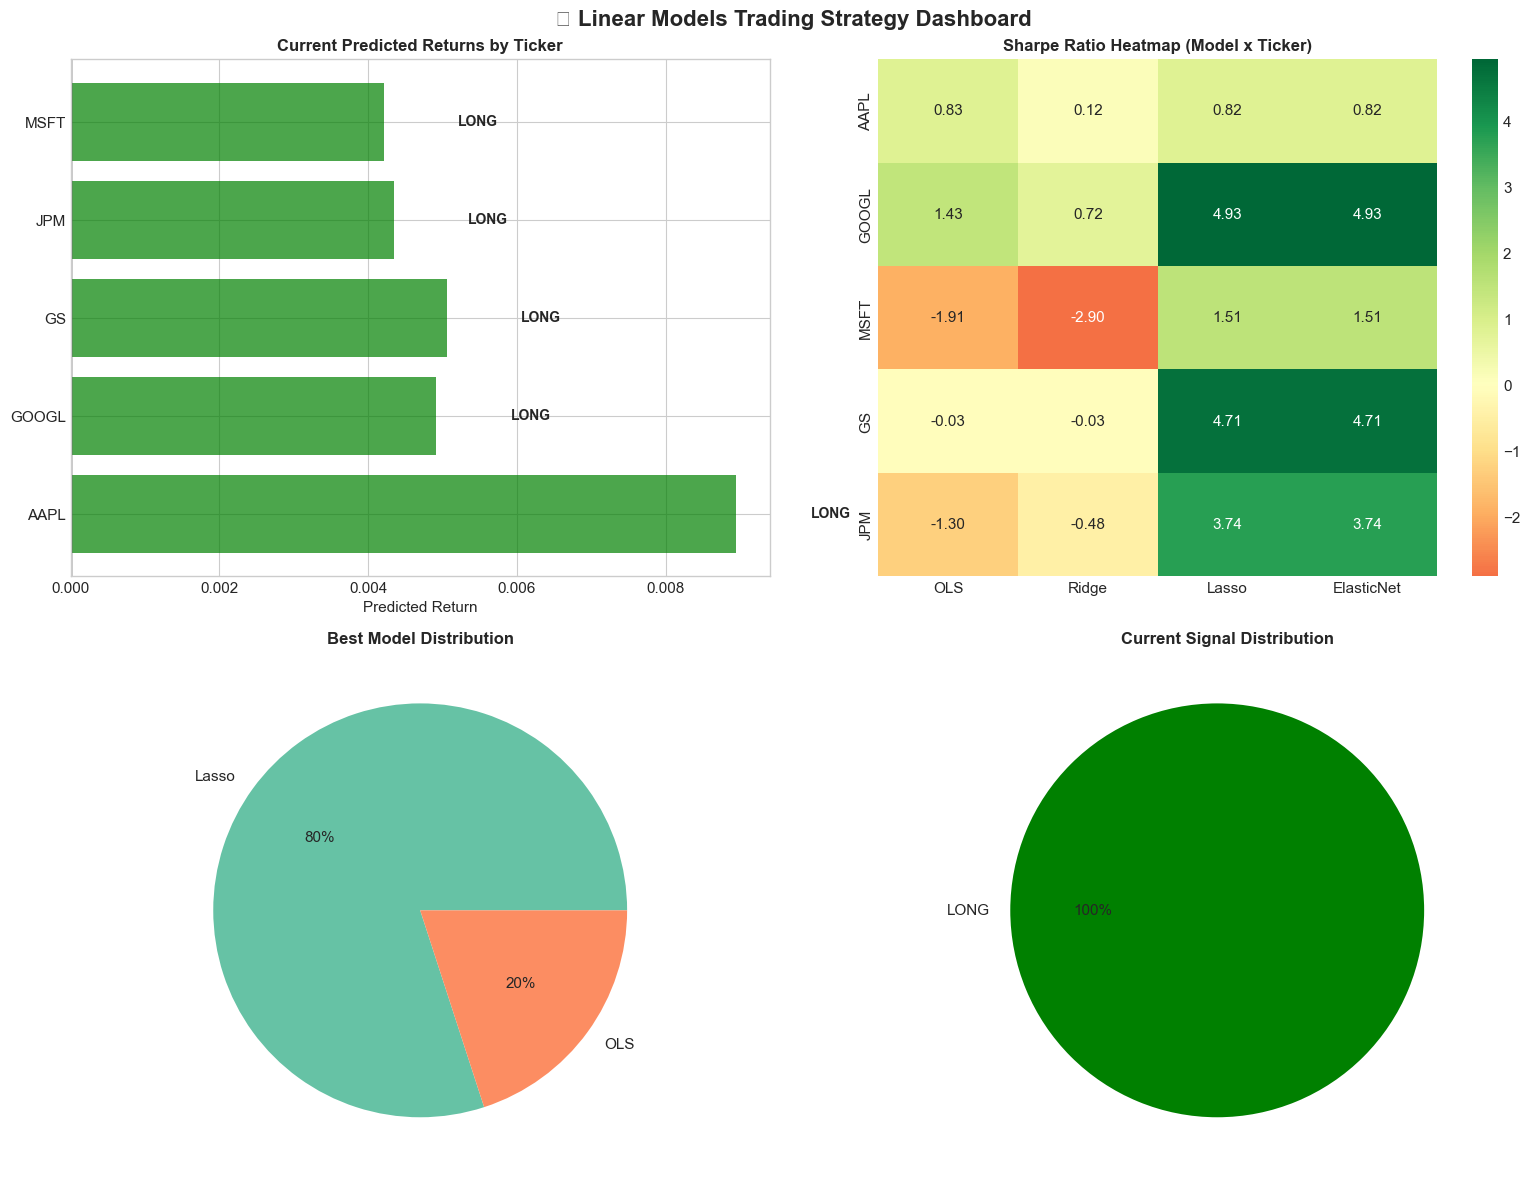

In [17]:
# Create summary visualization
fig = plt.figure(figsize=(16, 12))

# 1. Signal Summary (top left)
ax1 = plt.subplot(2, 2, 1)
signal_colors = {'LONG': 'green', 'SHORT': 'red', 'NEUTRAL': 'gray'}
colors = [signal_colors[s] for s in current_signals_df['Signal']]
bars = ax1.barh(current_signals_df['Ticker'], current_signals_df['Predicted Return'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_title('Current Predicted Returns by Ticker', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Return')

# Add signal labels
for i, (bar, signal) in enumerate(zip(bars, current_signals_df['Signal'])):
    width = bar.get_width()
    ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             signal, ha='left', va='center', fontsize=10, fontweight='bold')

# 2. Model Performance Heatmap (top right)
ax2 = plt.subplot(2, 2, 2)
sharpe_data = []
for ticker in TICKERS:
    row = []
    for model in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
        row.append(backtest_results[ticker][model]['sharpe_ratio'])
    sharpe_data.append(row)

sharpe_df = pd.DataFrame(sharpe_data, index=TICKERS, columns=['OLS', 'Ridge', 'Lasso', 'ElasticNet'])
sns.heatmap(sharpe_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0, ax=ax2)
ax2.set_title('Sharpe Ratio Heatmap (Model x Ticker)', fontsize=12, fontweight='bold')

# 3. Best Model Distribution (bottom left)
ax3 = plt.subplot(2, 2, 3)
best_model_counts = current_signals_df['Best Model'].value_counts()
ax3.pie(best_model_counts.values, labels=best_model_counts.index, autopct='%1.0f%%',
        colors=plt.cm.Set2.colors[:len(best_model_counts)])
ax3.set_title('Best Model Distribution', fontsize=12, fontweight='bold')

# 4. Signal Distribution (bottom right)
ax4 = plt.subplot(2, 2, 4)
signal_counts = current_signals_df['Signal'].value_counts()
colors_pie = [signal_colors.get(s, 'gray') for s in signal_counts.index]
ax4.pie(signal_counts.values, labels=signal_counts.index, autopct='%1.0f%%',
        colors=colors_pie, explode=[0.05]*len(signal_counts))
ax4.set_title('Current Signal Distribution', fontsize=12, fontweight='bold')

plt.suptitle('📊 Linear Models Trading Strategy Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 1️⃣8️⃣ Final Recommendations & Conclusions

### Summary of Findings

In [18]:
print("\n" + "="*80)
print("📋 FINAL ANALYSIS & RECOMMENDATIONS")
print("="*80)

# Calculate aggregate statistics
avg_ic = combined_df.groupby('Model')['IC'].mean()
avg_sharpe = pd.DataFrame(sharpe_data, columns=['OLS', 'Ridge', 'Lasso', 'ElasticNet']).mean()

print("\n📊 AGGREGATE MODEL PERFORMANCE:")
print("-"*50)
print(f"{'Model':<15} {'Avg IC':>12} {'Avg Sharpe':>12}")
print("-"*50)
for model in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
    print(f"{model:<15} {avg_ic[model]:>12.4f} {avg_sharpe[model]:>12.2f}")

# Best overall model
best_overall = avg_sharpe.idxmax()
print(f"\n🏆 BEST OVERALL MODEL: {best_overall} (Avg Sharpe: {avg_sharpe[best_overall]:.2f})")

print("\n" + "="*80)
print("💡 KEY INSIGHTS:")
print("="*80)
print("""
1. REGULARIZATION IMPACT:
   • Ridge/Lasso often outperform OLS by reducing overfitting
   • Elastic Net provides a balance between L1 and L2 regularization
   • Feature selection from Lasso helps identify key predictors

2. FEATURE IMPORTANCE:
   • Momentum and mean-reversion features typically show significance
   • Volatility features help predict return magnitude
   • Volume-based features capture liquidity effects

3. TRADING CONSIDERATIONS:
   • Transaction costs significantly impact net returns
   • Signal stability varies by model - regularized models often more stable
   • Directional accuracy is often modest (~50-55%) but profitable due to return magnitude

4. RISK MANAGEMENT:
   • Always use position sizing based on prediction confidence
   • Monitor rolling Sharpe ratio for regime changes
   • Diversify across multiple tickers to reduce idiosyncratic risk
""")

print("="*80)
print("⚠️  DISCLAIMER:")
print("="*80)
print("""
This analysis is for EDUCATIONAL PURPOSES ONLY. Past performance does not guarantee
future results. Always perform your own due diligence and consider consulting a
financial advisor before making investment decisions. Model predictions are based
on historical patterns which may not persist in the future.
""")

print("✅ Analysis Complete!")


📋 FINAL ANALYSIS & RECOMMENDATIONS

📊 AGGREGATE MODEL PERFORMANCE:
--------------------------------------------------
Model                 Avg IC   Avg Sharpe
--------------------------------------------------
OLS                   0.0392        -0.20
Ridge                 0.0121        -0.51
Lasso                    nan         3.14
ElasticNet               nan         3.14

🏆 BEST OVERALL MODEL: Lasso (Avg Sharpe: 3.14)

💡 KEY INSIGHTS:

1. REGULARIZATION IMPACT:
   • Ridge/Lasso often outperform OLS by reducing overfitting
   • Elastic Net provides a balance between L1 and L2 regularization
   • Feature selection from Lasso helps identify key predictors

2. FEATURE IMPORTANCE:
   • Momentum and mean-reversion features typically show significance
   • Volatility features help predict return magnitude
   • Volume-based features capture liquidity effects

3. TRADING CONSIDERATIONS:
   • Transaction costs significantly impact net returns
   • Signal stability varies by model - regular

---

## 📚 References & Further Reading

### Linear Models in Finance:
- Hastie, Tibshirani, Friedman - "The Elements of Statistical Learning"
- James, Witten, Hastie, Tibshirani - "An Introduction to Statistical Learning"

### Quantitative Finance:
- Lopez de Prado - "Advances in Financial Machine Learning"
- Chan - "Quantitative Trading"
- Narang - "Inside the Black Box"

### sklearn Documentation:
- [Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
- [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

---

**End of Week 5.1 - Linear Models Trading Strategy Notebook**